# Лабораторная работа №4. Рябиков Илья

## Импорт библиотек и данных

### Библиотеки

In [1]:
!pip install yfinance
!pip install statsmodels
!pip install riskfolio-lib
!pip install matplotlib==3.1.3
!pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
riskfolio-lib 3.3.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import yfinance as yf
import pandas as pd
from datetime import date

from scipy.stats import norm
import scipy.stats
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


### Данные

Скачаем ежедневные котировки акции Майкрософт и расчитаем ежедневные доходности

In [3]:
today = date.today()
df = yf.download('MSFT','2010-01-01', today)
df = df.dropna() ## remove NaN from the series

df['log_rtn'] = np.log(df['Adj Close']) - np.log(df['Adj Close'].shift(1))
df = df.dropna() ## remove NaN from the series

[*********************100%***********************]  1 of 1 completed


### Графики

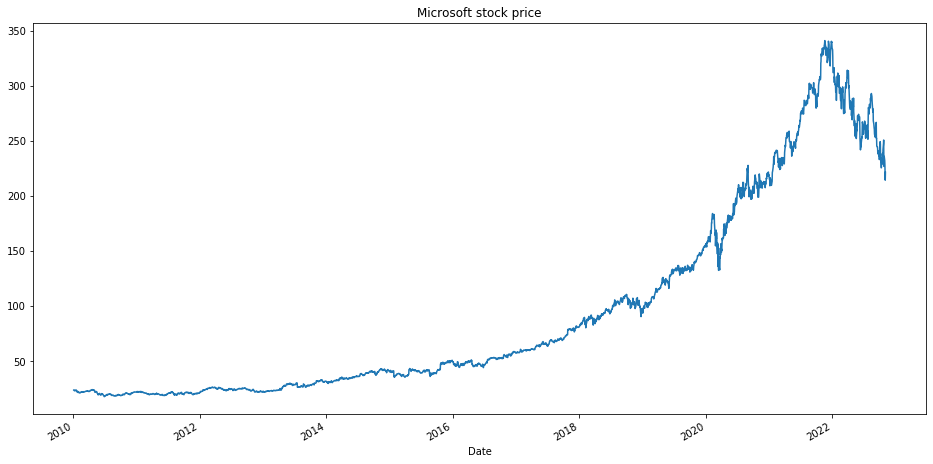

In [4]:
plt.rcParams["figure.figsize"] = [16,8] # set size for matplotlib charts 
df['Adj Close'].plot()
plt.title ('Microsoft stock price')
plt.show()

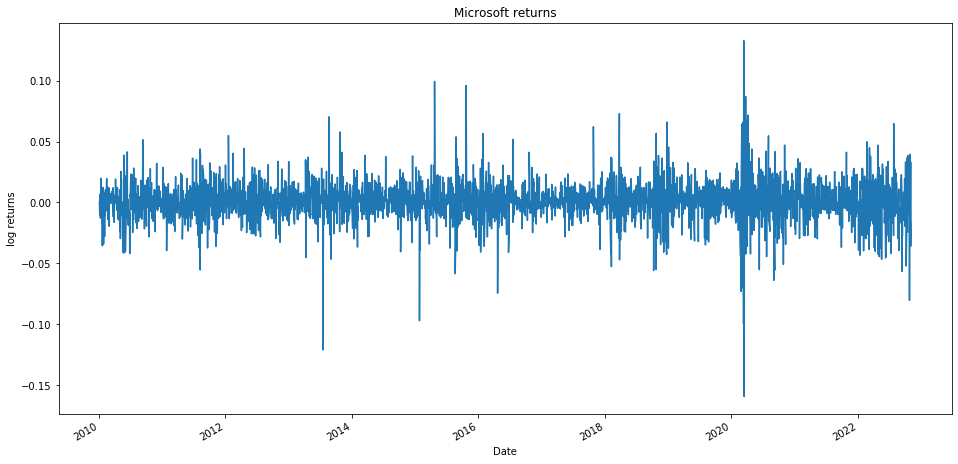

In [5]:
df['log_rtn'].plot()
plt.ylabel('log returns')
plt.title ('Microsoft returns')
plt.show()

Доходности в целом похожи на "белый шум", поэтому можно ожидать что-то похожее на нормальное распределение

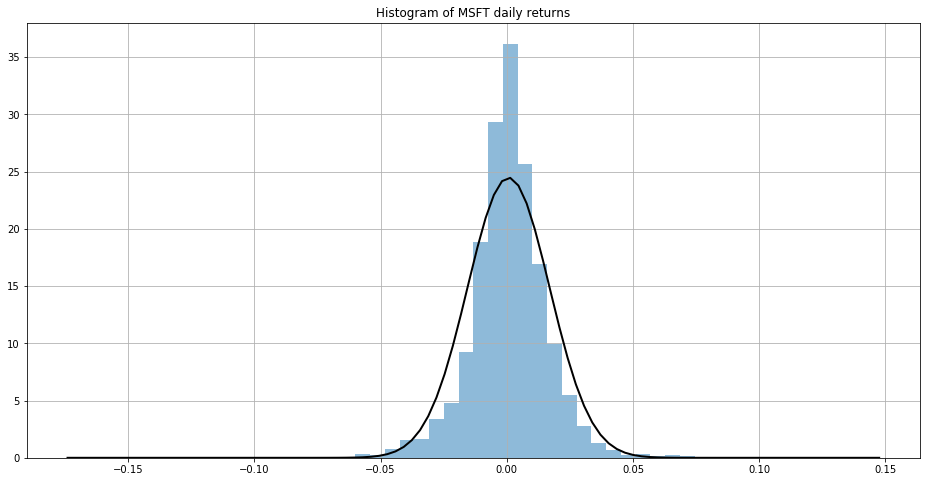

In [6]:
df["log_rtn"].hist(bins=50, density=True, histtype="stepfilled", alpha=0.5)
plt.title("Histogram of MSFT daily returns")
mu, std = norm.fit(df["log_rtn"]) 
std *np.sqrt(252) # SD of returns annualized 

xmin, xmax = plt.xlim() # plot normal curve 
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2) 
plt.show()

Распределение доходностей похоже на нормальное или Стьюдента

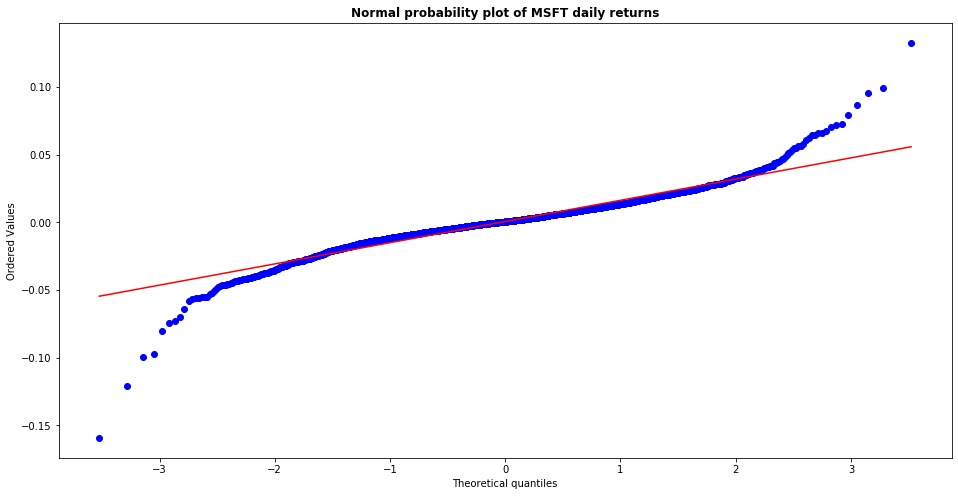

In [7]:
scipy.stats.probplot(df["log_rtn"],
                     dist=scipy.stats.norm,
                     plot=plt.figure().add_subplot(111))
plt.title("Normal probability plot of MSFT daily returns", weight="bold");

Судя по графику, распределение доходностей Майкрософта не очень похоже на нормальное - есть крайне сильное отклонение от "идеального" варианта

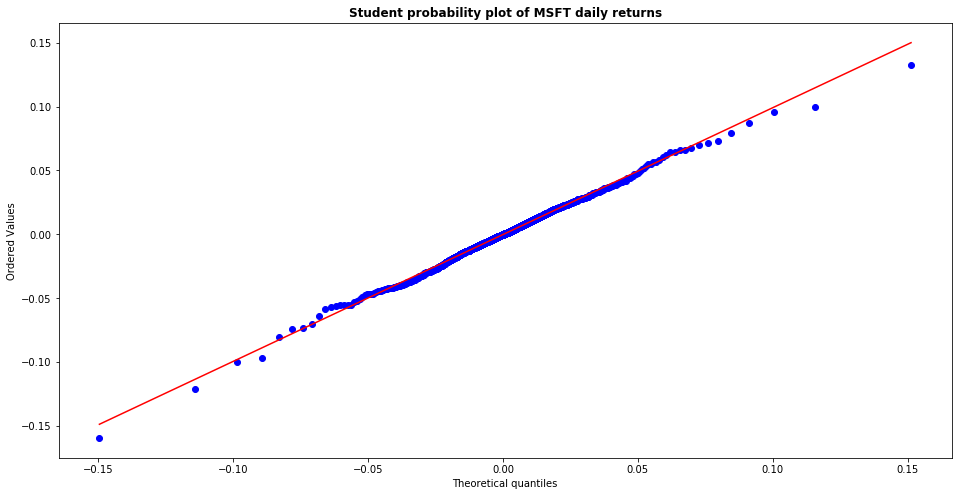

In [8]:
tdf, tmean, tsigma = scipy.stats.t.fit(df["log_rtn"])
scipy.stats.probplot(df["log_rtn"], 
                     dist=scipy.stats.t, 
                     sparams=(tdf, tmean, tsigma), 
                     plot=plt.figure().add_subplot(111))
plt.title("Student probability plot of MSFT daily returns", weight="bold");

А вот на распределение Стьюдента распределение доходностей похоже гораздо сильнее

## VaR and ES

### Bootstrap non-parametric VaR and ES

Расчитаем непараметрические VaR и ES для Майкрософта методом бутстрап, установим уровень значимости 5% и изначальный капитал в 1 млн. Построим также доверительный интервал для обоих показателей и гистограммы распределения

In [9]:
alpha = 0.05  # confidence level
capital = 10**6 # the initial value of the position 
q = df['log_rtn'].quantile(alpha)

In [10]:
var_nonparm = []
es_nonparm = []
N = 1000
alpha = 0.05

for i in range(1, N):
    sample = np.random.choice(df['log_rtn'], size = len(df['log_rtn']), replace=True) 
    q = np.quantile(sample, alpha)
    result = 10**6 * q
    var_nonparm.append(result)

    ie_var = df['log_rtn'] < q
    es_ = np.sum(np.multiply(df['log_rtn'], ie_var)) / np.sum(ie_var) * capital
    es_nonparm.append(es_)


Confidence interval:

Source: https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/

In [11]:
var_nonparm.sort()
lower = np.percentile(var_nonparm, (alpha)/2*100)
upper = np.percentile(var_nonparm, (1-alpha/2)*100)

In [12]:
print(f'{round((1-alpha)*100)}% confidence interval for VaR between {round(lower)} and {round(upper)}')

95% confidence interval for VaR between -27025 and -23001


In [13]:
es_nonparm.sort()
lower = np.percentile(es_nonparm, (alpha)/2*100)
upper = np.percentile(es_nonparm, (1-alpha/2)*100)

In [14]:
print(f'{round((1-alpha)*100)}% confidence interval for ES between {round(lower)} and {round(upper)}')

95% confidence interval for ES between -40084 and -36226


Plots:

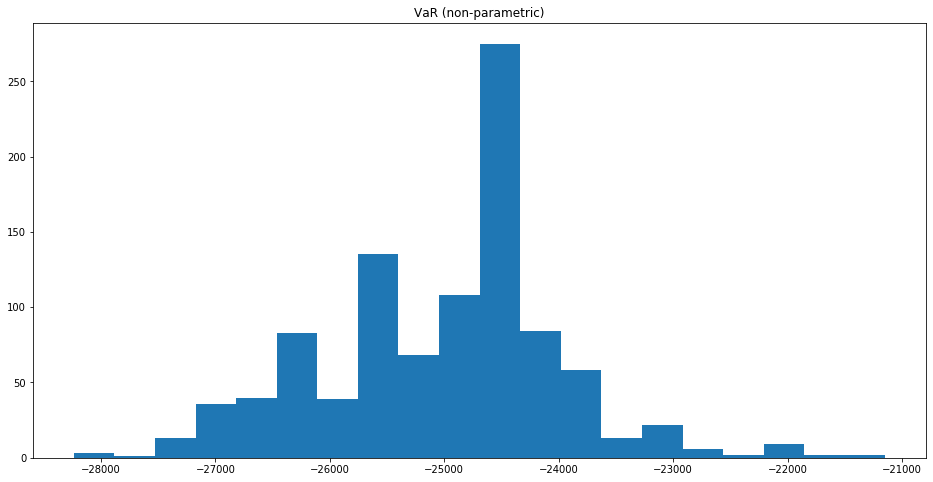

In [15]:
plt.hist(var_nonparm, bins = 20)
plt.title('VaR (non-parametric)')
plt.show()

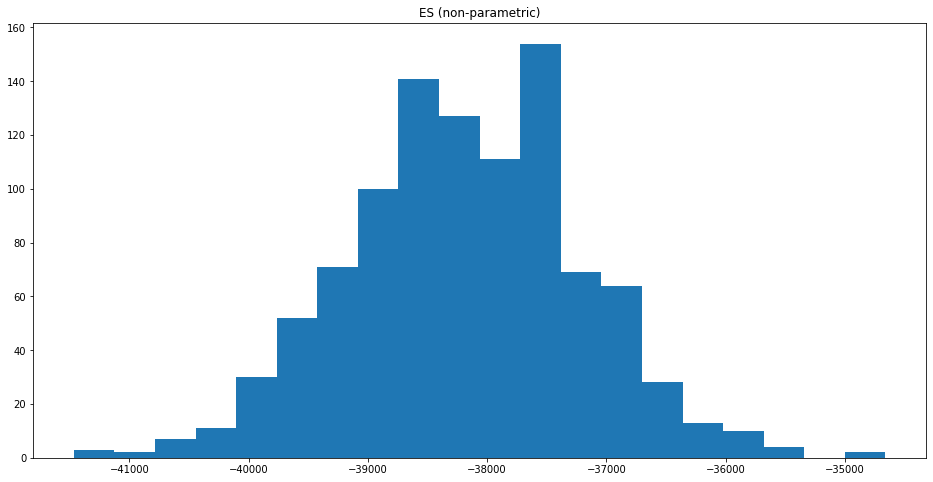

In [16]:
plt.hist(es_nonparm, bins = 20)
plt.title('ES (non-parametric)')
plt.show()

### Parametric VaR and ES normal distribution

Расчитаем параметрический VaR и ES для нормального распределения

In [17]:
mu = df['log_rtn'].mean()
sd = df['log_rtn'].std()

In [18]:
q = norm.ppf(1-alpha)

In [19]:
var_normal = -10**6 *(mu + sd*q)
round(var_normal/10000, 1) 

-2.8

С вероятностью 95% убытки составят не более чем 27506 долларов для капитала в 1 млн, что равно -2.7%

In [20]:
es_normal = -(alpha**-1 * norm.pdf(norm.ppf(alpha))*sd + mu) * capital
round(es_normal/10000, 1)

-3.4

Ожидаемый размер потерь для акций Майкрософта с вероятностью 95% составляет -3.4%, если мы приближаем распределение доходностей к нормальному

### Parametric Var and ES Student distribution

In [21]:
from scipy.stats import t

In [22]:
dist_t = t.ppf(1-alpha, 5)
nu = 5 # degrees of freedom 
var_t = -10**6 * (mu + np.sqrt((nu-2)/nu) * t.ppf(1-alpha, nu) * sd )
round(var_t/10000, 1)

-2.6

In [23]:
xanu = t.ppf(alpha, nu)
es_t = 10**6 *  (mu + 1/(alpha) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * sd )
round(es_t/10000, 1)

-3.6

Если мы приближаем распределение доходностей не к нормальному, а к распределению Стьюдента, то граница убытков для уровня значимости 95% сместится чуть выше - до -2.6%, но ожидаемый размер потерь также вырастет (поскольку распределение Стьюдента в отличие от нормального имеет более "толстые" хвосты.

Поскольку наше распределение дневных доходностей акций компании Майкрософт судя по графикам ближе к распределению Стьюдента, именно эта модель в данном анализе является ролевой.

### Bootstrap for parametric results

Normal distribution

In [24]:
var_parm_norm = []
es_parm_norm = []
N = 1000
alpha = 0.05

for i in range(1, N):
    sample = np.random.choice(df['log_rtn'], size = len(df['log_rtn']), replace=True) 
    # q = np.quantile(sample, alpha)
    mu = sample.mean()
    sd = sample.std()
    q = norm.ppf(1-alpha)
    result = -10**6 *(mu + sd*q)
    var_parm_norm.append(result)

    # ie_var = df['log_rtn'] < q
    es_ = -(alpha**-1 * norm.pdf(norm.ppf(alpha))*sd + mu) * capital
    es_parm_norm.append(es_)


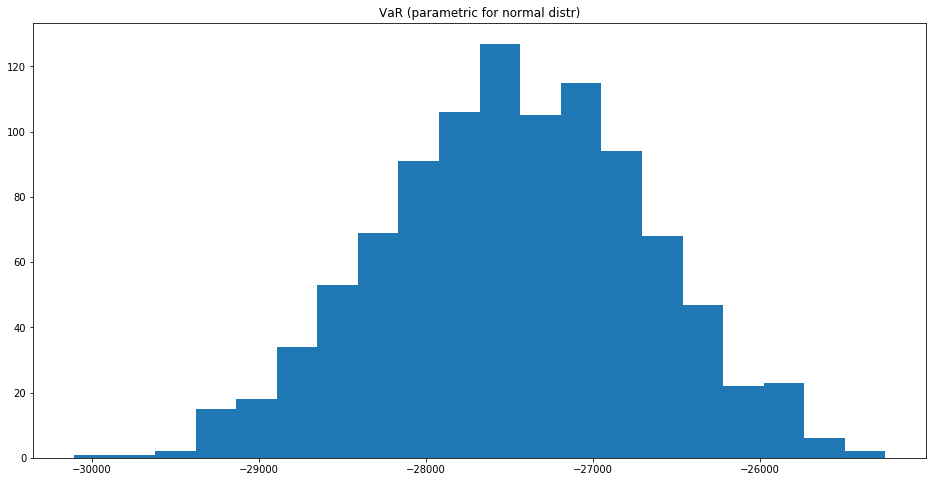

In [25]:
plt.hist(var_parm_norm, bins = 20)
plt.title('VaR (parametric for normal distr)')
plt.show()

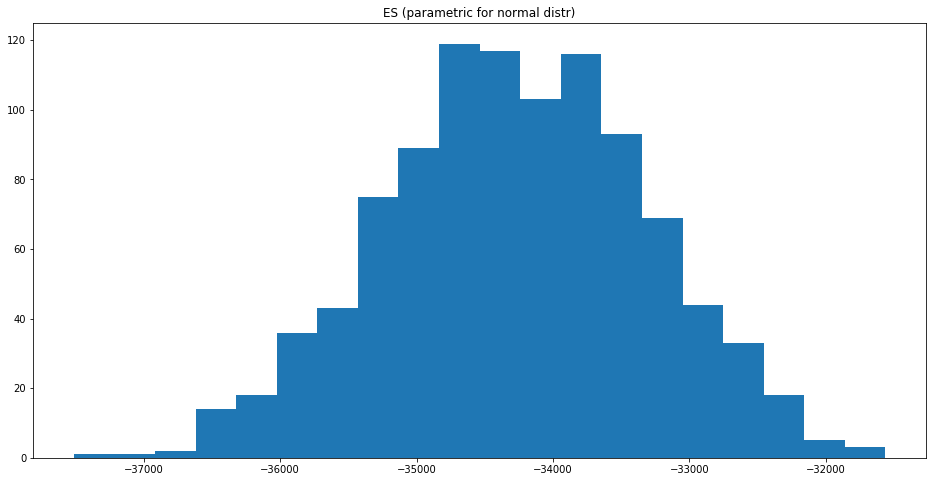

In [26]:
plt.hist(es_parm_norm, bins = 20)
plt.title('ES (parametric for normal distr)')
plt.show()

Student distribution

In [27]:
var_parm_stu = []
es_parm_stu = []
N = 1000
alpha = 0.05

for i in range(1, N):
    sample = np.random.choice(df['log_rtn'], size = len(df['log_rtn']), replace=True) 
    # q = np.quantile(sample, alpha)
    mu = sample.mean()
    sd = sample.std()
    q = norm.ppf(1-alpha)
    nu = 5 # degrees of freedom 
    result = -10**6 * (mu + np.sqrt((nu-2)/nu) * t.ppf(1-alpha, nu) * sd )
    var_parm_stu.append(result)

    xanu = t.ppf(alpha, nu)
    es_ = 10**6 *  (mu + 1/(alpha) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * sd )
    es_parm_stu.append(es_)


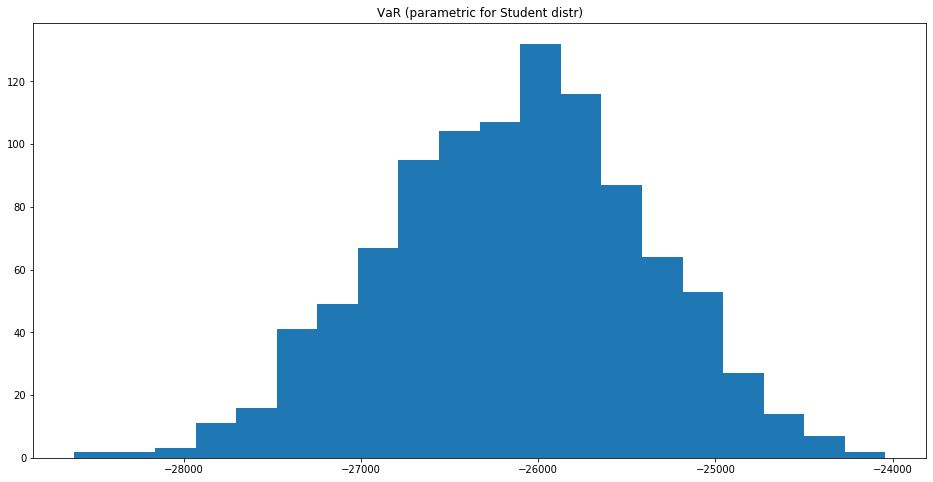

In [28]:
plt.hist(var_parm_stu, bins = 20)
plt.title('VaR (parametric for Student distr)')
plt.show()

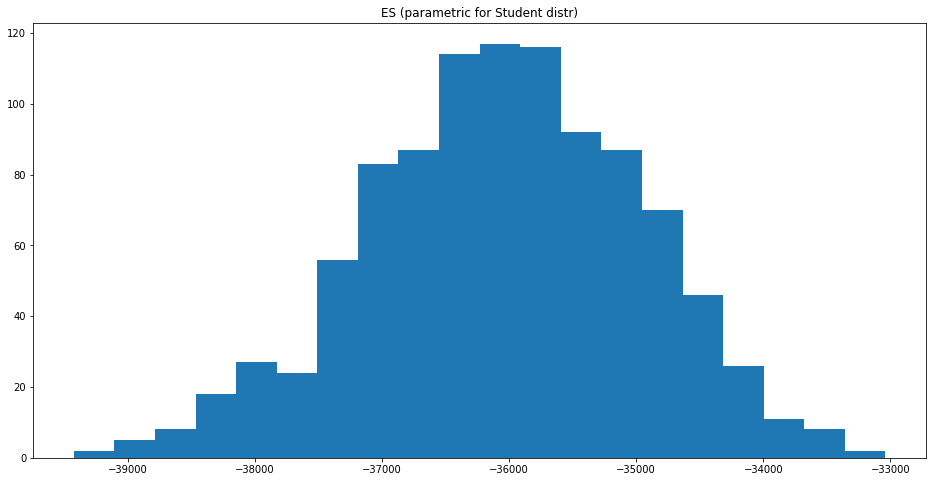

In [29]:
plt.hist(es_parm_stu, bins = 20)
plt.title('ES (parametric for Student distr)')
plt.show()

Аналогичные соотношения VaR и ES мы можем видеть у метода бутстрап - для VaR нормальное распределение предсказывает более низкую границу убытков, чем для Стьюдента, но распределение значений ES у Стьюдента сильнее смещено в отрицательную сторону. 

## Вывод

Таким образом, были проанализированны показатели VaR и ES для акций компании Майкрософт, VaR показывает границу убытков - уровень потерь, который не будет превышен с заданой вероятностью, а ES - ожидаемый размер потерь. 

Были использованы 3 метода для оценки этих показателей - непараметрический, параметрический с нормальным распределением и параметрический с распределением Стьюдента. Первый метод имеет наименьший VaR и наибольший ES, второй метод - наибольший VaR и наименьший ES, а третий и там и там показал средние значения. Это наблюдалось и для бутстрап-расчетов и для обычной калькуляции показателя. Это объясняется особенностью распределения доходностей акций компании, но в целом значения различаются не очень сильно.

Для непараметрического бутстрапа был расчитан также доверительный интервал для обоих показателей. 